In [47]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [50]:
train_path = "train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head(10)

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...
7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...
8,One Step Away (1985),crime,Ron Petrie (Keanu Reeves) is a troubled teen ...
9,"""Desperate Hours"" (2016)",reality-tv,"A sudden calamitous event, causing great loss..."
10,Spirits (2014/I),horror,Four high school students embark on a terrify...


In [51]:
test_path = "test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head(10)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...
9,10,Press (2011),Press is a story of young people overwhelmed ...


In [52]:
test_soln_path = "test_data_solution.txt"
test_soln_data = pd.read_csv(test_soln_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_soln_data.drop(test_soln_data.columns[[0, 2]], axis=1, inplace=True)
test_soln_data.rename(columns = {'Title':'Actual Genre'}, inplace = True)
test_soln_data.head(10)

,Actual Genre
1,thriller
2,comedy
3,documentary
4,drama
5,drama
6,horror
7,drama
8,comedy
9,documentary
10,drama


In [53]:
train_data.Genre.value_counts()

Genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

Text(0, 0.5, 'Distribution of Genres')

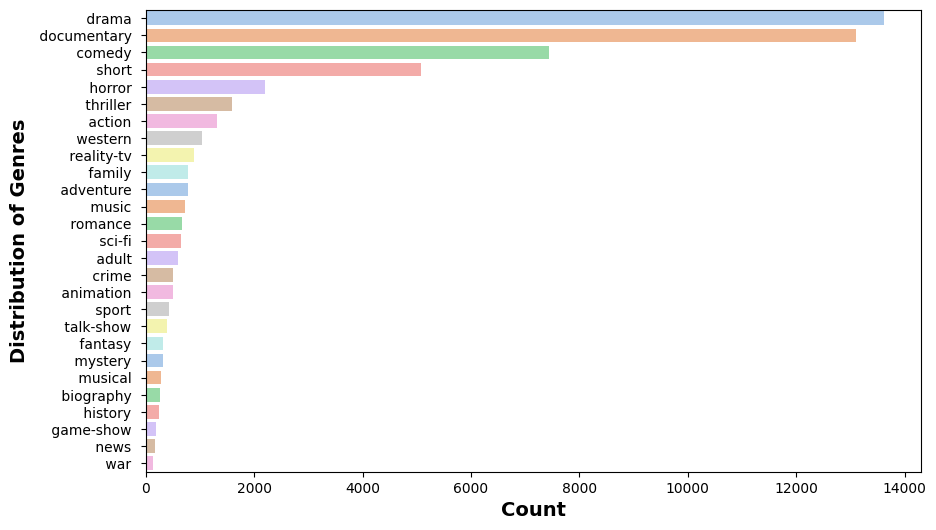

In [54]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("pastel")
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette=palette)
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Distribution of Genres', fontsize=14, fontweight='bold')

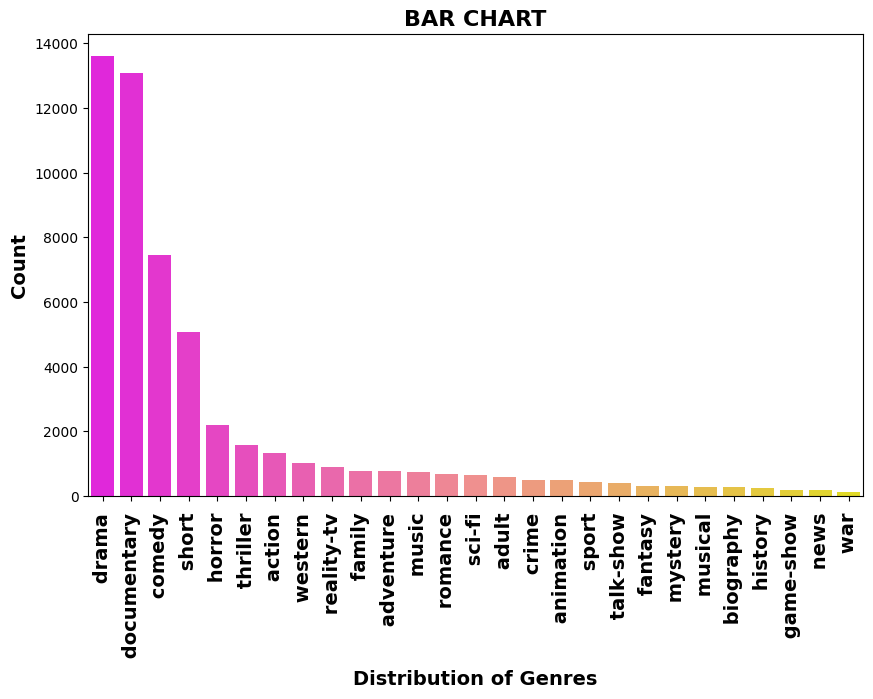

In [55]:
plt.figure(figsize=(10, 6))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='spring')
plt.xlabel('Distribution of Genres', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('BAR CHART', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

In [56]:
train_data.info()
#Finda any null value
train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Title          0
Genre          0
Description    0
dtype: int64

In [57]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [58]:
# Droping the redundant data
print("shape before drop nulls",train_data.shape)
train_data = train_data.drop_duplicates()
print("shape after drop nulls",train_data.shape)

shape before drop nulls (54214, 4)
shape after drop nulls (54214, 4)


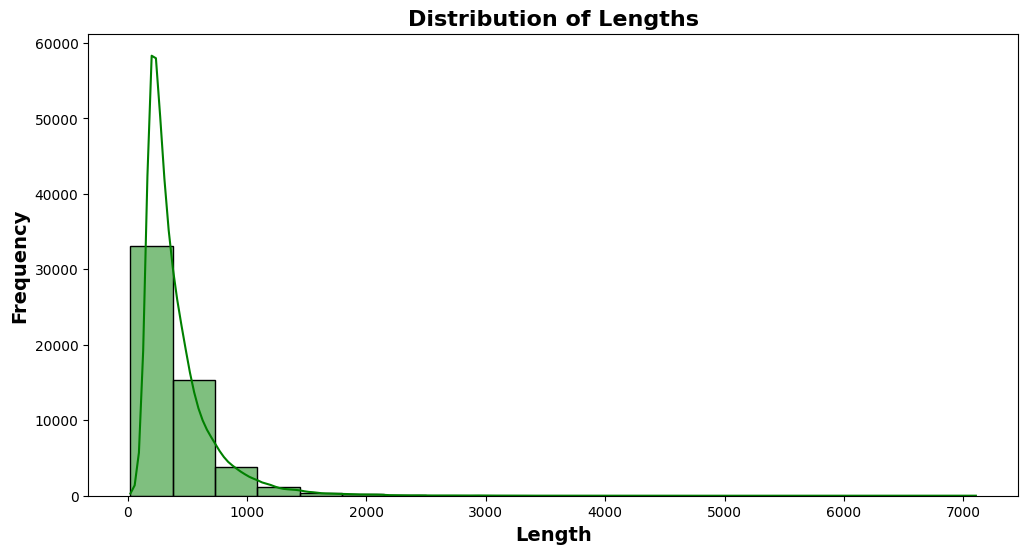

In [59]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='green')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()



Text(0, 0.5, 'Frequency')

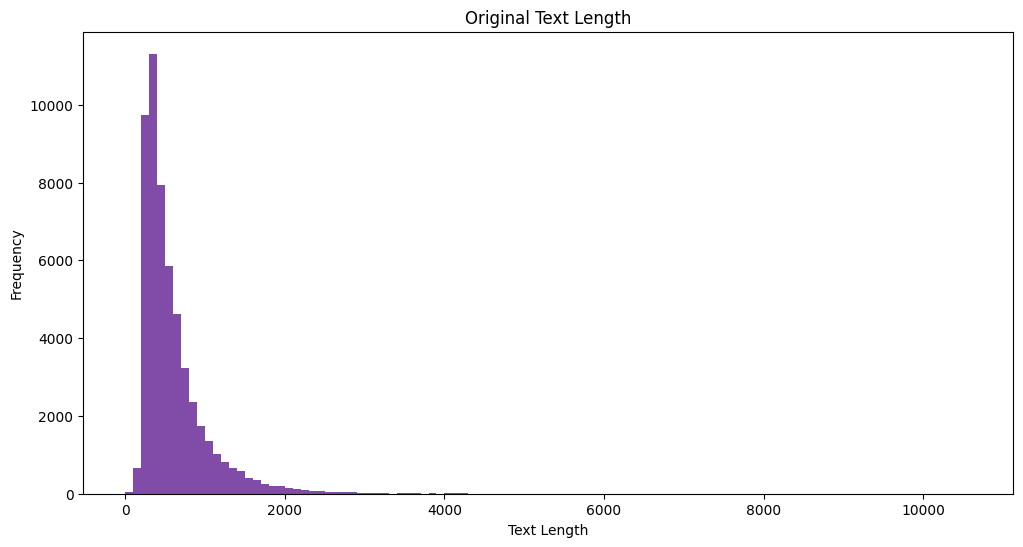

In [60]:
plt.figure(figsize=(12, 6))
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='indigo', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

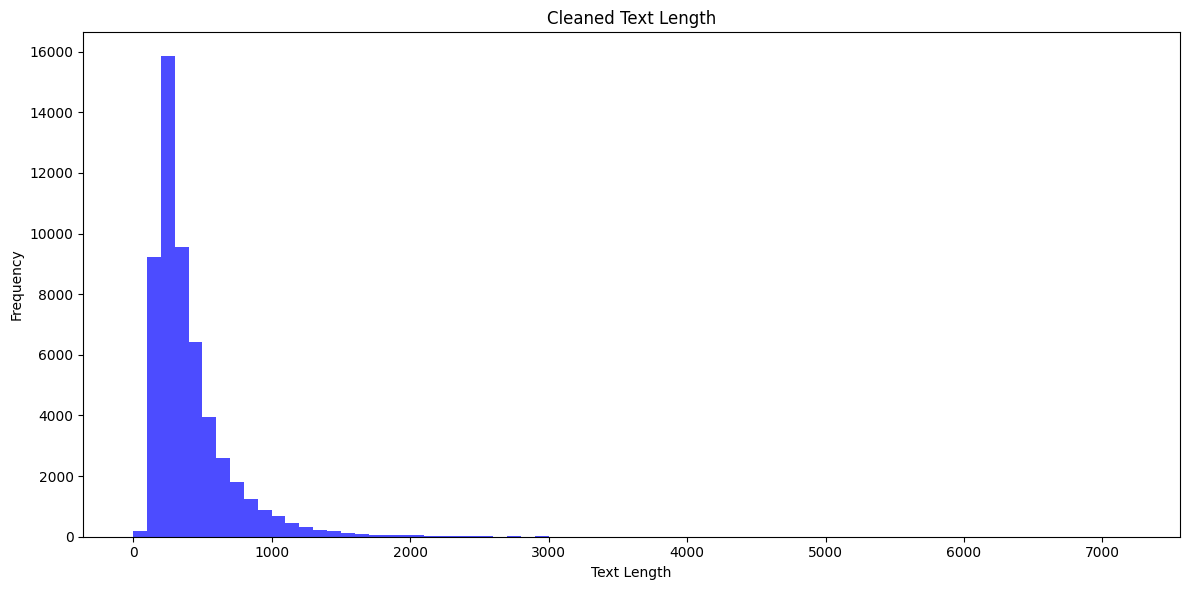

In [61]:
plt.figure(figsize=(12, 6))
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [62]:
# @title Text Vectorization (TF-IDF)
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [63]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
import warnings
warnings.filterwarnings("ignore")

# Initialize and train a Multinomial Naive Bayes Classifier
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf_NB.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

In [65]:
accuracy_NB = accuracy_score(y_val, y_pred)
accuracy_NB

0.44526422576777647

In [66]:
# Initialize and train a Logistic Regression Classifier
clf_logreg = LogisticRegression(multi_class='multinomial', solver='sag')
clf_logreg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf_logreg.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5795444065295582
               precision    recall  f1-score   support

      action        0.61      0.22      0.32       263
       adult        0.86      0.17      0.28       112
   adventure        0.45      0.10      0.16       139
   animation        0.67      0.02      0.04       104
   biography        0.00      0.00      0.00        61
      comedy        0.52      0.59      0.55      1443
       crime        1.00      0.01      0.02       107
 documentary        0.65      0.87      0.74      2659
       drama        0.53      0.81      0.64      2697
      family        0.50      0.05      0.10       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.92      0.30      0.45        40
     history        0.00      0.00      0.00        45
      horror        0.67      0.55      0.60       431
       music        0.71      0.38      0.49       144
     musical        0.00      0.00      0.00        50
     mystery        0.00

In [67]:
accuracy_logreg = accuracy_score(y_val, y_pred)
accuracy_logreg

0.5795444065295582

In [68]:
X_test_predictions = clf_NB.predict(X_test)
test_data['Predicted_Genre_NB'] = X_test_predictions
# Logistic Regression
# Use the trained model to make predictions on the test data
X_test_predictions = clf_logreg.predict(X_test)
test_data['Predicted_Genre_LR'] = X_test_predictions

In [69]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('predicted_genres.csv', index=False)

# Add actual genre column to predicted dataFrame
extracted_col = test_soln_data["Actual Genre"]
test_data.insert(5, "Actual Genre", extracted_col)
# Display the 'test_data' DataFrame with predicted and actual genres
test_data.head()

,Id,Title,Description,Text_cleaning,Predicted_Genre_NB,Actual Genre,Predicted_Genre_LR
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...,drama,NaN,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...,drama,thriller,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...,documentary,comedy,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...,drama,documentary,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...,drama,drama,drama
